4 Prediction Models for the Financial Stress Index, or Market Stress Intensity
- Random Forest outpreformed our other models and weighted the predictors in a more consistent manner
- 86% accuracy predicting future high market stress events

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time

import pandas_datareader.data as web
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

- DGS10 = 10-Year treasury Yield
- TB3MS = 3-Month Treasury Bill Yield
- VIXCLS = CBOE Volatility Index
- TEDRATE = TED Spread or Interbank risk spread
- BAA10Y = BAA Corporate Spread
- WTISPLC = WTI Oil Price
- spread = DGS10 - TB3MS
- STLFSI4 = Financial Stress Index

In [3]:
predictors = web.DataReader(["VIXCLS", "DGS10", "TB3MS", "TEDRATE", "BAA10Y", "WTISPLC"], "fred", "1977-01-01", "2025-01-01")
predictors["spread"] = predictors["DGS10"] - predictors["TB3MS"]

predictors1 = predictors.resample('QS').mean()
predictors1.columns = ["VIXCLS", "DGS10", "TB3MS", "TEDRATE", "BAA10Y", "WTISPLC", "spread"]
predictors1["C_VIXCLS"] = (predictors1['VIXCLS']/predictors1['VIXCLS'].shift(4))-1
predictors1["C_WTISPLC"] = (predictors1["WTISPLC"]/predictors1["WTISPLC"].shift(4))-1
predictors1 = predictors1.dropna()

predictors2 = predictors1.drop(['VIXCLS', 'WTISPLC'], axis=1)

In [4]:
MSIw = web.DataReader(["STLFSI4"], "fred", "1977-01-01", "2025-01-01")
MSIQ = MSIw.resample('QS').mean()

alldata = predictors2.shift(1).dropna()
alldata["MSIQ"] = MSIQ["STLFSI4"]

In [5]:
X = alldata.drop(['MSIQ'], axis=1).copy()
y = alldata['MSIQ'].copy()
y = (alldata['MSIQ'] > 0).astype(int)

mask = y.notna()
X = X.loc[mask]
y = y.loc[mask]

y.mean()

np.float64(0.3620689655172414)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.25, random_state=123)

len(X_train), len(y_train), len(X_test), len(y_test)

(87, 87, 29, 29)

In [7]:
model = LogisticRegression()
model.fit(X_train, y_train)
yhat_logistic = model.predict(X_test)

accuracy_score(y_test, yhat_logistic)


0.8275862068965517

In [8]:
model1 = KNeighborsClassifier(n_neighbors = 3)
model1.fit(X_train, y_train)
yhat_trainKNN = model1.predict(X_train)
yhat_testKNN = model1.predict(X_test)

accuracy_score(y_train, yhat_trainKNN)

0.9080459770114943

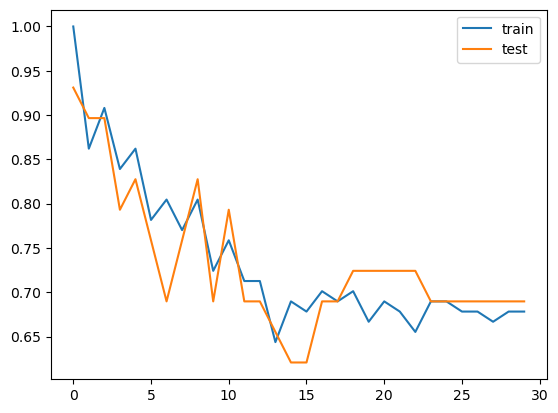

In [9]:
maxneighbors = 30
trainscore = []
testscore = []
for i in range(1, maxneighbors+1):
    model2 = KNeighborsClassifier(n_neighbors=i)
    model2.fit(X_train, y_train)
    yhat_trainMN = model2.predict(X_train) 
    yhat_testMN = model2.predict(X_test)
    trainscore.append(accuracy_score(y_train, yhat_trainMN))
    testscore.append(accuracy_score(y_test, yhat_testMN))
trainscore_np = np.array(trainscore)
testscore_np = np.array(testscore)

plt.plot(trainscore, label='train')
plt.plot(testscore, label = 'test')
plt.legend()
plt.show()

In [10]:
model3 = DecisionTreeClassifier()
model3.fit(X_train, y_train)
yhat_trainDTC = model3.predict(X_train)
yhat_testDTC = model3.predict(X_test)

accuracy_score(y_test, yhat_testDTC)

0.7586206896551724

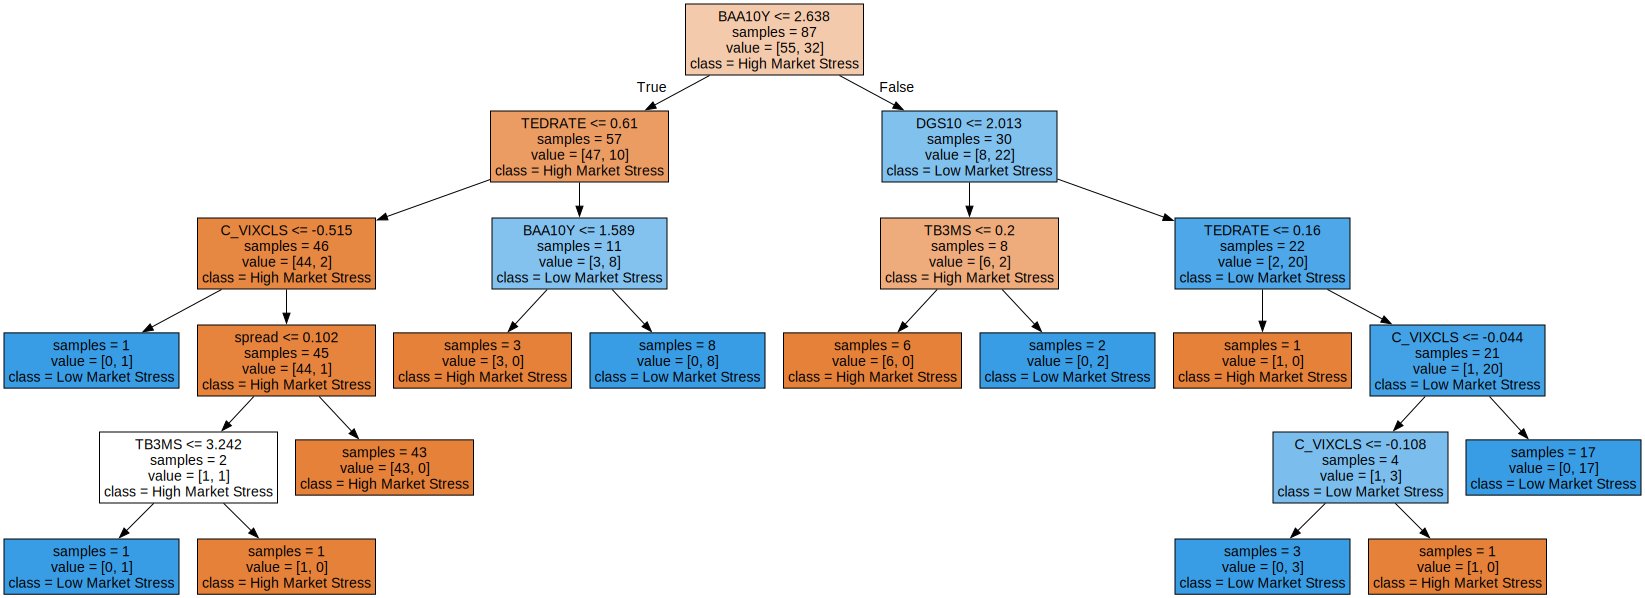

In [11]:
export_graphviz(model3, out_file = "tree.dot", class_names = ["High Market Stress", "Low Market Stress"], feature_names=X.columns, impurity=False, filled=True)

with open("tree.dot") as file:
    decision_tree=file.read()
graphviz.Source(decision_tree)

([<matplotlib.axis.YTick at 0x281e6f42710>,
 [Text(0, 0, 'DGS10'),
  Text(0, 1, 'TB3MS'),
  Text(0, 2, 'TEDRATE'),
  Text(0, 3, 'BAA10Y'),
  Text(0, 4, 'spread'),
  Text(0, 5, 'C_VIXCLS'),
  Text(0, 6, 'C_WTISPLC')])

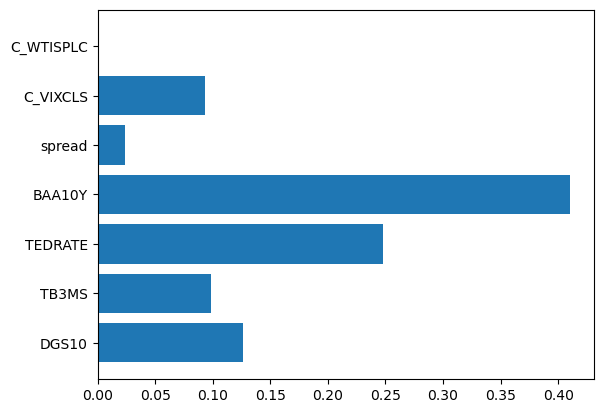

In [12]:
plt.barh(range(len(X_train.columns)), model3.feature_importances_)
plt.yticks(range(len(X_train.columns)), X_train.columns)

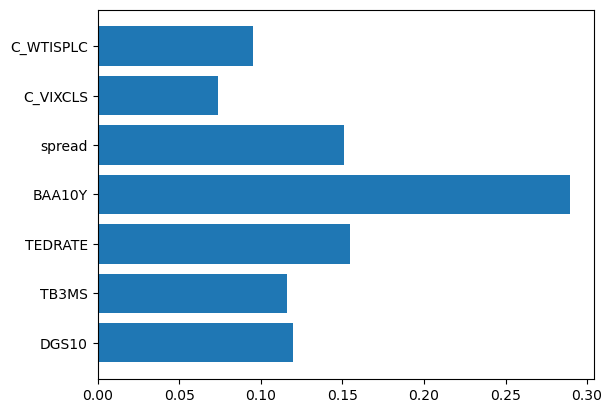

In [13]:
#Best Model for MSI
model4 = RandomForestClassifier(n_estimators=20)
model4.fit(X_train, y_train)
yhat_trainRFC = model4.predict(X_train)
yhat_testRFC = model4.predict(X_test)

plt.barh(range(len(X_train.columns)), model4.feature_importances_)
plt.yticks(range(len(X_train.columns)), X_train.columns)
plt.show()

In [14]:
accuracy_score(y_test, yhat_testRFC)

0.8275862068965517

In [15]:
model5 = GradientBoostingClassifier(max_depth=3, n_estimators=20)
model5.fit(X_train, y_train)
yhat_trainGB = model5.predict(X_train)
yhat_testGB = model5.predict(X_test)

accuracy_score(y_test, yhat_testGB)

0.8620689655172413

In [16]:
#to find optimal estimators
maxtrees = 50
trainscore = []
testscore = []
for i in range(1, maxtrees+1):
    model5 = GradientBoostingClassifier(max_depth=3, n_estimators=i)
    model5.fit(X_train, y_train)
    yhat_trainGB = model5.predict(X_train)
    yhat_testGB = model5.predict(X_test)
    trainscore.append(accuracy_score(y_train, yhat_trainGB))
    testscore.append(accuracy_score(y_test, yhat_testGB))
trainscore_np=np.array(trainscore)
testscore_np=np.array(testscore)

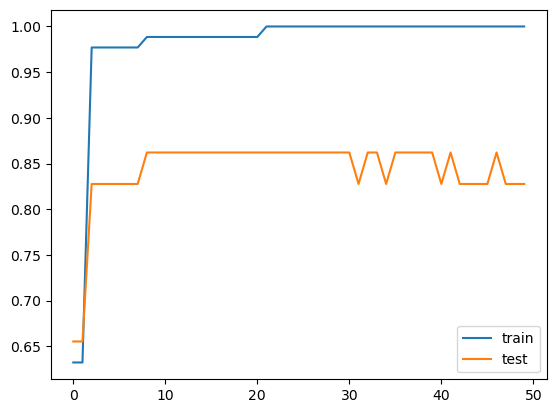

In [17]:
plt.plot(trainscore_np, label="train")
plt.plot(testscore, label='test')
plt.legend()
plt.show()

In [18]:
y_probability = model.predict_proba(X_test)[:, 1]
print("Accuracy:", accuracy_score(y_test, yhat_testGB))
print("ROC-AUC:", roc_auc_score(y_test, y_probability))
print(classification_report(y_test, yhat_testGB))

Accuracy: 0.8275862068965517
ROC-AUC: 0.9263157894736842
              precision    recall  f1-score   support

           0       0.89      0.84      0.86        19
           1       0.73      0.80      0.76        10

    accuracy                           0.83        29
   macro avg       0.81      0.82      0.81        29
weighted avg       0.83      0.83      0.83        29



In [19]:
#high stress here is considered the top quarter of values above 0 for MSIQ. can change.
def prob_high_stress_next_years(alldata, years, n_estimators=20, max_depth=3):
    horizon = int(4 * years)  # quarterly -> years
    df = alldata.copy()
    positive_vals = df.loc[df["MSIQ"] > 0, "MSIQ"]
    threshold = positive_vals.quantile(0.75)
    df["HighStress_now"] = ((df["MSIQ"] > threshold) & (df["MSIQ"] > 0)).astype(int)
    df["HighStress_future"] = df["HighStress_now"].shift(-horizon)
    df = df.dropna(subset=["HighStress_future"])
    df = df.dropna(subset=["HighStress_future"])
    
    X = df.drop(columns=["MSIQ", "HighStress_now", "HighStress_future"])
    y = df["HighStress_future"].astype(int)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)
    
    model = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators)
    model.fit(X_train, y_train)
    
    prob_latest = model.predict_proba(alldata.drop(columns=["MSIQ"]).tail(1))[:, 1][0]
    print(f"Probability of high market stress within {years} years: {prob_latest:.2%}")
    
    return prob_latest

prob_high_stress_next_years(alldata, 1)
prob_high_stress_next_years(alldata, 2)


Probability of high market stress within 1 years: 4.63%
Probability of high market stress within 2 years: 0.00%


np.float64(0.0)

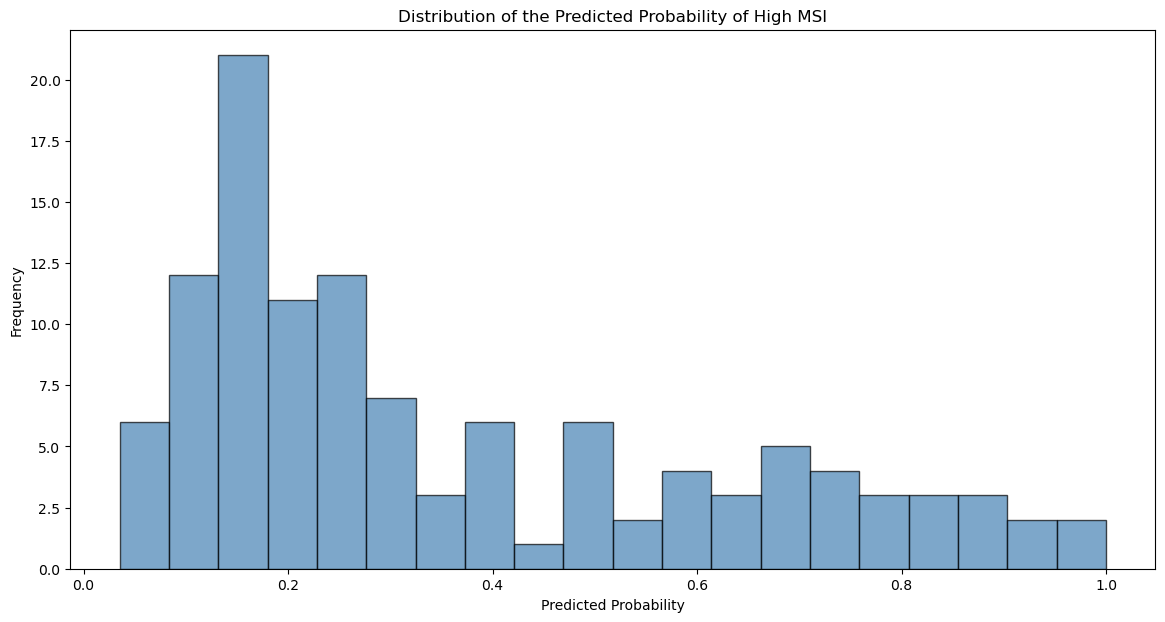

In [20]:
results = pd.DataFrame(index=X.index)
results["Predicted_Prob"] = model.predict_proba(X)[:, 1]

plt.figure(figsize=(14,7))
plt.hist(results["Predicted_Prob"], bins=20, color='steelblue', edgecolor='black', alpha=0.7)
plt.title("Distribution of the Predicted Probability of High MSI")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.show()
